In [1]:
%matplotlib inline

import json
import math

import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from itertools import groupby
from collections import defaultdict

In [2]:
class Experiment:
    def __init__(self, name, input_file, parameters, rounds):
        self.__name = name
        self.__input_file = input_file
        self.__parameters = parameters
        self.__rounds = rounds
        
    @property
    def name(self):
        return self.__name
    
    @property
    def input_file(self):
        return self.__input_file
    
    @property
    def parameters(self):
        return self.__parameters
    
    @property
    def rounds(self):
        return self.__rounds
    
    def __repr__(self):
        return 'Experiment(name={0}, input_file={1}, parameters={2})'.format(
            self.__name, self.__input_file, self.__parameters)
    
class Round:
    def __init__(self, duration, objective, n):
        self.__duration = duration
        self.__objective = objective
        self.__n = n
        
    @property
    def duration(self):
        return self.__duration
    
    @property
    def objective(self):
        return self.__objective
    
    @property
    def n(self):
        return self.__n
    
    def __repr__(self):
        return 'Round(duration={0}, objective={1}, n={2})'.format(
            self.__duration, self.__objective, self.__n)
    
class DriverRound:
    def __init__(self, duration, device, n):
        self.__duration = duration
        self.__device = device
        self.__n = n
        
    @property
    def duration(self):
        return self.__duration
    
    @property
    def device(self):
        return self.__device
    
    @property
    def n(self):
        return self.__n
    
    def __repr__(self):
        return 'Round(duration={0}, device={1}, n={2})'.format(
            self.__duration, self.__device, self.__n)

In [3]:
class ExperimentLogParser:
    @abstractmethod
    def parse(self, file_path):
        pass

class PrefixExperimentLogParser(ExperimentLogParser):
    def __init__(self, prefix, parameters):
        self.__prefix = prefix
        self.__parameters = parameters
    
    def parse(self, file_path, no_params=False):
        with open(file_path, 'r') as f:
            lines = PrefixExperimentLogParser.filter_lines(f.readlines(), self.__prefix)
            
            start_idx = 1
            
            if no_params:
                start_idx = 0
            
            rounds = []
            for line in lines[start_idx:]:
                round_prop = json.loads(line)
                rounds.append(Round(round_prop['duration'], round_prop['objective'], round_prop['round']))
                
            experiment_prop = json.loads(lines[0])
            
            if no_params:
                name = ''
                input_file = ''
                parameters = {}
            else:
                name = experiment_prop['name']
                input_file = experiment_prop['inputFile']
                parameters = {
                    'eta': experiment_prop['eta'],
                    'lambda': experiment_prop['lambda'],
                    'H': experiment_prop['localIterFrac'],
                    'K': experiment_prop['numSplits']
                }
            
            return Experiment(name, input_file, parameters, rounds)
        
    @staticmethod
    def filter_lines(lines, prefix):
        return [line[line.find(prefix) + len(prefix):] for line in lines if prefix in line]
    
class PrefixDriverWithExperimentLogParser(ExperimentLogParser):
    def __init__(self, prefix, parameters):
        self.__prefix = prefix
        self.__parameters = parameters
    
    def parse(self, driver_log_path, file_path, no_params=False):
        with open(driver_log_path, 'r') as f_d:
            lines_d = PrefixExperimentLogParser.filter_lines(f_d.readlines(), self.__prefix)
            
            with open(file_path, 'r') as f_f:
                lines_f = PrefixExperimentLogParser.filter_lines(f_f.readlines(), self.__prefix)
                
                rounds_d = []
                for line in lines_d[1:]:
                    round_prop = json.loads(line)
                    rounds_d.append(DriverRound(round_prop['duration'], round_prop['device'], round_prop['round']))

                rnd_duration = {}
                for rnd, devices in groupby(rounds_d, lambda r: r.n):
                    rnd_duration[rnd] = max(devices, key=lambda d: d.duration).duration
                    
                experiment_prop = json.loads(lines_d[0])

                if no_params:
                    name = ''
                    input_file = ''
                    parameters = {}
                else:
                    name = experiment_prop['name']
                    input_file = experiment_prop['inputFile']
                    parameters = {
                        'eta': experiment_prop['eta'],
                        'lambda': experiment_prop['lambda'],
                        'H': experiment_prop['localIterFrac'],
                        'K': experiment_prop['numSplits']
                    }

                #device = json.loads(lines_f[0])['device']
                
                #rnd_duration = {rnd.n: rnd.duration for rnd in rounds_d if rnd.device == device}
                    
                rounds_f = []
                for line in lines_f[0:]:
                    round_prop = json.loads(line)
                    rounds_f.append(Round(rnd_duration[round_prop['duration']], round_prop['objective'], round_prop['round']))
            
            return Experiment(name, input_file, parameters, rounds_f)
        
    @staticmethod
    def filter_lines(lines, prefix):
        return [line[line.find(prefix) + len(prefix):] for line in lines if prefix in line]

In [4]:
class ExperimentLogPlotter:
    def __init__(self):
        self.__experiments = []
        self.__names = []
        self.__figsize = (8, 6)
        self.__ylim = 1e-4
        self.__yticks = [10e-1, 10e-2, 10e-3, 10e-4]
        self.__xlabel = "Seconds"
        self.__ylabel = ""
        self.__grid = False
        self.__which_grid = "both"
        self.__markers = ['x', 'o', 'v', '^', '.', '+', 'd']
        self.__use_iterations = False
        self.__every_n = []
        self.__title = ""
        self.__objective_min = 0
        
    def add_experiment(self, experiment, name=None, every_n=1):
        self.__experiments.append(experiment)
        self.__every_n.append(every_n)
        if name:
            self.__names.append(name)
        else:
            self.__names.append(experiment.name)
    
    def figsize(self, figsize):
        self.__figsize = figsize
        
    def ylim(self, ylim):
        self.__ylim = ylim
        
    def yticks(self, ticks):
        self.__yticks = ticks
        
    def ylabel(self, label):
        self.__ylabel = label
        
    def enable_grid(self, which):
        self.__which_grid = which
        
    def use_iterations(self):
        self.__use_iterations = True
        self.__xlabel = "Iterations"
        
    def add_min_objective(self, objective):
        self.__objective_min = objective
    
    def title(self, title):
        self.__title = title
    
    def plot(self, filename=None):
        timestamps, objectives = ExperimentLogPlotter._prepare_experiments(self.__experiments, self.__objective_min, self.__ylim)
        
        plt.figure(figsize=self.__figsize)
        
        plt.ylim(self.__ylim)
        plt.yticks(self.__yticks)
        plt.xlabel(self.__xlabel)
        plt.ylabel(self.__ylabel)
        plt.grid(self.__grid, which=self.__which_grid)
        plt.xlim((0, ExperimentLogPlotter._max_timestamp(timestamps)))
        plt.title(self.__title)
        
        for i in range(len(timestamps)):
            timestamp = timestamps[i][::self.__every_n[i]]
            objective = objectives[i][::self.__every_n[i]]
            
            if self.__use_iterations:
                timestamp = np.arange(len(timestamp)) * self.__every_n[i]

            plt.loglog(timestamp, objective, marker=self.__markers[i])
        
        plt.legend(self.__names, loc='upper right')
        plt.autoscale(axis='x')
        plt.xlim(xmin=0)
        
        if filename:
            plt.savefig(filename, transparent=True)
        
    @staticmethod
    def _max_timestamp(timestamps):
        max_timestamp = -np.inf
        for timestamp in timestamps:
            current_max = timestamp.max()
            if current_max > max_timestamp:
                max_timestamp = current_max
        return max_timestamp
      
    @staticmethod
    def _prepare_experiments(experiments, min_objective, cut_off=1e-4):
        timestamps = []
        objectives = []
        
        for i, experiment in enumerate(experiments):
            timestamps_arr = np.cumsum([rnd.duration / 1000 for rnd in experiment.rounds])
            objectives_arr = np.array([rnd.objective for rnd in experiment.rounds])
            
            #objectives_arr = objectives_arr - objectives_arr.min()
            objectives_arr = objectives_arr - min_objective
            
            max_idx = -1
            for i, objective in enumerate(objectives_arr):
                if objective < cut_off:
                    max_idx = i
                    break
            
            timestamps.append(timestamps_arr[:max_idx])
            objectives.append(objectives_arr[:max_idx])
        
        min_objective = np.inf
        for objective in objectives:
            current_min = objective.min()
            if current_min < min_objective:
                min_objective = current_min
        
        #objectives = [objective - min_objective for objective in objectives]
        
        return timestamps, objectives

In [5]:
input_path_exa = '/Users/Chris/Studies/thesis/experiment_results/exa/exp_exa_epsilon_h01_2/exp_exa_epsilon_h01_2_091.txt'
input_path_exa_2 = '/Users/Chris/Studies/thesis/experiment_results/exa/exp_exa_epsilon_h01_s3/exp_exa_epsilon_h01_s3_091.txt'
input_path_exa_3 = '/Users/Chris/Studies/thesis/experiment_results/exa/exp_exa_epsilon_h005_s3/exp_exa_epsilon_h005_s3_091.txt'
input_path_exa_driver_2 = '/Users/Chris/Studies/thesis/experiment_results/exa/exp_exa_epsilon_h01_s3.txt'
input_path_exa_driver_3 = '/Users/Chris/Studies/thesis/experiment_results/exa/exp_exa_epsilon_h005_s3.txt'
input_path_local = '/Users/Chris/Studies/thesis/experiment_results/local/exp_local_epsilon_h01.txt'
input_path_spark = '/Users/Chris/Studies/thesis/experiment_results/spark/exp_spark_epsilon_h01.txt'

In [6]:
parser_spark = PrefixExperimentLogParser(prefix='EXPERIMENT|', parameters=['eta', 'lambda', 'localIterFrac', 'numSplits'])
parser_local = PrefixExperimentLogParser(prefix='EXPERIMENT|', parameters=['eta', 'lambda', 'localIterFrac', 'numSplits'])
parser_fw = PrefixExperimentLogParser(prefix='EXPERIMENT|', parameters=['eta', 'lambda', 'localIterFrac', 'numSplits'])
parser_fw_2 = PrefixDriverWithExperimentLogParser(prefix='EXPERIMENT|', parameters=['eta', 'lambda', 'localIterFrac', 'numSplits'])

In [7]:
#plotter = ExperimentLogPlotter()
#plotter.add_experiment(parser_local.parse(input_path_local), name='Local', every_n=20)
#plotter.add_experiment(parser_spark.parse(input_path_spark), name='Spark', every_n=50)
#plotter.ylabel(r'Suboptimality: $O_B(w) - O_B(w^*)$')
#plotter.ylim(1e-4)
#plotter.figsize((8, 6))
#plotter.title('Epsilon - Suboptimality vs. Time')
#plotter.plot()

In [8]:
input_path_url_exa = '/Users/Chris/Studies/thesis/experiment_results/exa/test.txt'
input_path_url_spark = '/Users/Chris/Studies/thesis/experiment_results/spark/exp_spark_url_h1.txt'

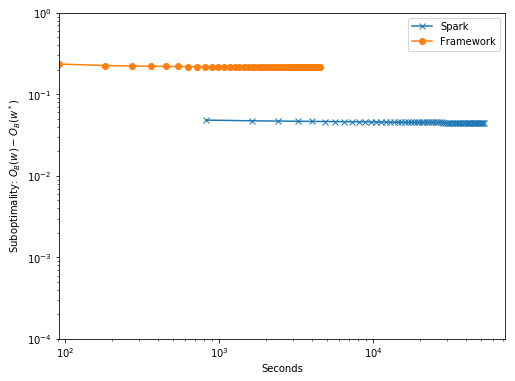

In [9]:
plotter = ExperimentLogPlotter()
plotter.add_experiment(parser_spark.parse(input_path_url_spark), 'Spark', every_n=100)
plotter.add_experiment(parser_fw.parse(input_path_url_exa, no_params=True), 'Framework', every_n=100)
plotter.ylabel(r'Suboptimality: $O_B(w) - O_B(w^*)$')
plotter.ylim(1e-4)
plotter.plot()

In [10]:
class ExperimentDoubleLogPlotter:
    def __init__(self):
        self.__experiments = []
        self.__names = []
        self.__figsize = (8, 6)
        self.__ylim = 1e-4
        self.__yticks = [10e-1, 10e-2, 10e-3, 10e-4]
        self.__xlabel = "Seconds"
        self.__ylabel = ""
        self.__grid = False
        self.__which_grid = "both"
        self.__markers = ['x', 'o', 'v', '^', 'h', '+', 'd', 'p', '*', 's', '<', '>', 'H']
        self.__use_iterations = False
        self.__every_n = []
        self.__title = []
        self.__subplots = []
        self.__objective_mins = {}
        
    def add_experiment(self, experiment, subplot=1, name=None, every_n=1):
        self.__experiments.append(experiment)
        self.__every_n.append(every_n)
        self.__subplots.append(subplot)
        if name:
            self.__names.append(name)
        else:
            self.__names.append(experiment.name)
    
    def figsize(self, figsize):
        self.__figsize = figsize
        
    def ylim(self, ylim):
        self.__ylim = ylim
        
    def yticks(self, ticks):
        self.__yticks = ticks
        
    def ylabel(self, label):
        self.__ylabel = label
        
    def enable_grid(self, which):
        self.__which_grid = which
        
    def use_iterations(self):
        self.__use_iterations = True
        self.__xlabel = "Iterations"
    
    def title(self, title, subplot=1):
        self.__title.append(title)
    
    def add_min_objectives(self, objective, subplot):
        self.__objective_mins[subplot] = objective
    
    def plot(self, filename=None):
        timestamps, objectives = ExperimentDoubleLogPlotter._prepare_experiments(self.__experiments, self.__objective_mins, self.__subplots, self.__ylim)
        
        n_subplots = max(self.__subplots)
        
        f, axarr = plt.subplots(nrows=1, ncols=n_subplots, figsize=self.__figsize)
        legends = defaultdict(list)
        
        for i in range(n_subplots):
            axarr[i].set_ylim(self.__ylim)
            axarr[i].set_yticks(self.__yticks)
            axarr[i].set_xticks([10e0, 10e1, 10e2, 10e3, 10e4])
            axarr[i].set_xlabel(self.__xlabel)
            axarr[i].set_ylabel(self.__ylabel)
            axarr[i].grid(self.__grid, which=self.__which_grid)
            #axarr[i].set_xlim((0, ExperimentLogPlotter._max_timestamp(timestamps)))
            axarr[i].set_title(self.__title[i])
        
        for i in range(len(timestamps)):
            timestamp = timestamps[i][::self.__every_n[i]]
            objective = objectives[i][::self.__every_n[i]]
            subplot = self.__subplots[i]
            name = self.__names[i]
            legends[subplot-1].append(name)
            
            if self.__use_iterations:
                timestamp = np.arange(len(timestamp)) * self.__every_n[i]

            axarr[subplot-1].loglog(timestamp, objective, marker=self.__markers[i])
        
        for i in range(n_subplots):
            axarr[i].legend(legends[i], loc='upper right')
            axarr[i].autoscale(axis='x')
            axarr[i].set_xlim(xmin=0)
            
        if filename:
            f.savefig(filename, transparent=True)
        
    @staticmethod
    def _max_timestamp(timestamps):
        max_timestamp = -np.inf
        for timestamp in timestamps:
            current_max = timestamp.max()
            if current_max > max_timestamp:
                max_timestamp = current_max
        return max_timestamp
      
    @staticmethod
    def _prepare_experiments(experiments, min_objectives, subplots, cut_off=1e-4):
        timestamps = []
        objectives = []
        
        for i, experiment in enumerate(experiments):
            timestamps_arr = np.cumsum([rnd.duration / 1000 for rnd in experiment.rounds])
            objectives_arr = np.array([rnd.objective for rnd in experiment.rounds])
            
            #objectives_arr = objectives_arr - objectives_arr.min()
            objectives_arr = objectives_arr - min_objectives[subplots[i]]
            
            max_idx = -1
            for i, objective in enumerate(objectives_arr):
                if objective < cut_off:
                    max_idx = i
                    break
            
            timestamps.append(timestamps_arr[:max_idx])
            objectives.append(objectives_arr[:max_idx])
        
        min_objective = np.inf
        for objective in objectives:
            current_min = objective.min()
            if current_min < min_objective:
                min_objective = current_min
        
        #objectives = [objective - min_objective for objective in objectives]
        
        return timestamps, objectives

In [11]:
plotter = ExperimentDoubleLogPlotter()
plotter.add_experiment(parser_local.parse(input_path_local), name='Local', every_n=20)
plotter.add_experiment(parser_spark.parse(input_path_spark), name='Spark', every_n=50)
plotter.add_experiment(parser_fw.parse(input_path_exa, no_params=True), name='Framework', every_n=100)
plotter.add_experiment(parser_fw_2.parse(input_path_exa_driver_2, input_path_exa_2), subplot=2, name='Framework SSP=3, H=0.1', every_n=100)
plotter.add_experiment(parser_fw_2.parse(input_path_exa_driver_3, input_path_exa_3), subplot=2, name='Framework SSP=3, H=0.05', every_n=100)
plotter.ylabel(r'Suboptimality: $O_B(w) - O_B(w^*)$')
plotter.ylim(1e-4)
plotter.figsize((14, 6))
plotter.title('Epsilon - Suboptimality vs. Time', subplot=1)
plotter.title('URL - Suboptimality vs. Time', subplot=2)
plotter.plot()

KeyError: 1

# Experiments

## Algorithm Performance

In [12]:
base_path = '/Users/Chris/Studies/thesis/experiment_results/'

In [13]:
parser_spark = PrefixExperimentLogParser(prefix='EXPERIMENT|', parameters=['eta', 'lambda', 'localIterFrac', 'numSplits'])
parser_local = PrefixExperimentLogParser(prefix='', parameters=['eta', 'lambda', 'localIterFrac', 'numSplits'])
parser_local_2 = PrefixExperimentLogParser(prefix='EXPERIMENT|', parameters=['eta', 'lambda', 'localIterFrac', 'numSplits'])
parser_framework = PrefixDriverWithExperimentLogParser(prefix='EXPERIMENT|', parameters=['eta', 'lambda', 'localIterFrac', 'numSplits'])
parser_framework_2 = PrefixExperimentLogParser(prefix='EXPERIMENT|', parameters=['eta', 'lambda', 'localIterFrac', 'numSplits'])
parser_framework_driver = PrefixDriverWithExperimentLogParser(prefix='EXPERIMENT|', parameters=['eta', 'lambda', 'localIterFrac', 'numSplits'])

### Results - Epsilon Dataset

In [14]:
alg_epsilon_local_path = base_path + 'local/exp_local_epsilon_h1.txt'
alg_epsilon_spark_path = base_path + 'spark/exp_spark_epsilon_h1.txt'
alg_epsilon_framework_path = base_path + 'exa/exp_exa_epsilon_h1/exp_exa_epsilon_h1_091.txt'

### Results - URL Dataset

In [15]:
alg_url_local_path = base_path + 'local/exp_local_url_h1.txt'
alg_url_spark_path = base_path + 'spark/exp_spark_url_h1.txt'
alg_url_framework_path = base_path + 'exa/exp_exa_url_h1/exp_exa_url_h1_091.txt'

### Figure

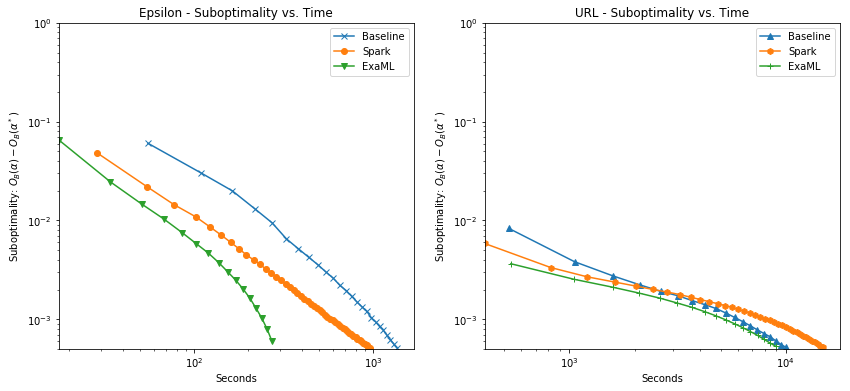

In [17]:
plotter = ExperimentDoubleLogPlotter()
# Epsilon
plotter.add_experiment(parser_local.parse(alg_epsilon_local_path), subplot=1, name='Baseline', every_n=1)
plotter.add_experiment(parser_spark.parse(alg_epsilon_spark_path), subplot=1, name='Spark', every_n=5)
plotter.add_experiment(parser_framework_2.parse(alg_epsilon_framework_path, no_params=True), subplot=1, name='ExaML', every_n=5)
# URL
plotter.add_experiment(parser_local_2.parse(alg_url_local_path), subplot=2, name='Baseline', every_n=10)
plotter.add_experiment(parser_spark.parse(alg_url_spark_path), subplot=2, name='Spark', every_n=50)
plotter.add_experiment(parser_framework_2.parse(alg_url_framework_path, no_params=True), subplot=2, name='ExaML', every_n=100)

plotter.ylabel(r'Suboptimality: $O_B(\alpha) - O_B(\alpha^*)$')
plotter.ylim(5e-4)
plotter.figsize((14, 6))
plotter.title('Epsilon - Suboptimality vs. Time', subplot=1)
plotter.title('URL - Suboptimality vs. Time', subplot=2)
#plotter.use_iterations()

plotter.add_min_objectives(objective=0.21720414, subplot=1)
plotter.add_min_objectives(objective=0.045041505, subplot=2)

plotter.plot(filename='./../img/overall_perf_cmp.png',)

## Communication Frequency

### Results - Epsilon Dataset

In [19]:
#comm_epsilon_local_path = base_path + 'local/exp_local_epsilon_h1.txt'
comm_epsilon_spark_h01_path = base_path + 'spark/exp_spark_epsilon_h01.txt'
comm_epsilon_spark_h1_path = base_path + 'spark/exp_spark_epsilon_h1.txt'
comm_epsilon_framework_h1_path = base_path + 'exa/exp_exa_epsilon_h1_s3/exp_exa_epsilon_h1_090.txt'
comm_epsilon_framework_h05_path = base_path + 'exa/exp_exa_epsilon_h05_s3/exp_exa_epsilon_h05_s3_090.txt'
comm_epsilon_framework_h01_path = base_path + 'exa/exp_exa_epsilon_h01_s3/exp_exa_epsilon_h01_s3_090.txt'
comm_epsilon_framework_h005_path = base_path + 'exa/exp_exa_epsilon_h005_s3/exp_exa_epsilon_h005_s3_090.txt'

### Results - URL Dataset

In [20]:
#alg_url_local_path = ''
comm_url_spark_h01_path = base_path + 'spark/exp_spark_url_h01.txt'
comm_url_spark_h1_path = base_path + 'spark/exp_spark_url_h1.txt'
comm_url_framework_h1_path = base_path + 'exa/exp_exa_url_h1/exp_exa_url_h1_091.txt'
comm_url_framework_h02_path = base_path + 'exa/exp_exa_url_h02_tap/exp_exa_url_h02_tap_091.txt'
comm_url_framework_h05_path = base_path + 'exa/exp_exa_url_h05/exp_exa_url_h05_091.txt'

### Figure

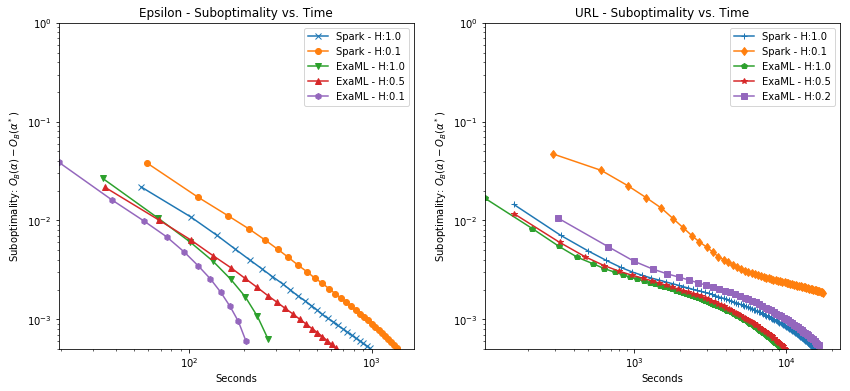

In [21]:
plotter = ExperimentDoubleLogPlotter()
# Epsilon
plotter.add_experiment(parser_spark.parse(comm_epsilon_spark_h1_path), subplot=1, name='Spark - H:1.0', every_n=10)
plotter.add_experiment(parser_spark.parse(comm_epsilon_spark_h01_path), subplot=1, name='Spark - H:0.1', every_n=50)
plotter.add_experiment(parser_framework_2.parse(comm_epsilon_framework_h1_path, no_params=True), subplot=1, name='ExaML - H:1.0', every_n=10)
plotter.add_experiment(parser_framework_2.parse(comm_epsilon_framework_h05_path, no_params=True), subplot=1, name='ExaML - H:0.5', every_n=20)
plotter.add_experiment(parser_framework_2.parse(comm_epsilon_framework_h01_path, no_params=True), subplot=1, name='ExaML - H:0.1', every_n=50)
#plotter.add_experiment(parser_framework_2.parse(comm_epsilon_framework_h005_path, no_params=True), subplot=1, name='Framework - H:0.05', every_n=100)

# URL
plotter.add_experiment(parser_spark.parse(comm_url_spark_h1_path), subplot=2, name='Spark - H:1.0', every_n=20)
plotter.add_experiment(parser_spark.parse(comm_url_spark_h01_path), subplot=2, name='Spark - H:0.1', every_n=50)
plotter.add_experiment(parser_framework_2.parse(comm_url_framework_h1_path, no_params=True), subplot=2, name='ExaML - H:1.0', every_n=20)
plotter.add_experiment(parser_framework_2.parse(comm_url_framework_h05_path, no_params=True), subplot=2, name='ExaML - H:0.5', every_n=50)
plotter.add_experiment(parser_framework_2.parse(comm_url_framework_h02_path, no_params=True), subplot=2, name='ExaML - H:0.2', every_n=200)

plotter.ylabel(r'Suboptimality: $O_B(\alpha) - O_B(\alpha^*)$')
plotter.ylim(5e-4)
plotter.figsize((14, 6))
plotter.title('Epsilon - Suboptimality vs. Time', subplot=1)
plotter.title('URL - Suboptimality vs. Time', subplot=2)
#plotter.use_iterations()

plotter.add_min_objectives(objective=0.21719499, subplot=1)
plotter.add_min_objectives(objective=0.04503669, subplot=2)

plotter.plot(filename='./../img/comm_freq_cmp.png')

## Syncronization Strategy

### Results - Epsilon

In [22]:
sst_epsilon_framework_bsp = base_path + 'exa/exp_exa_epsilon_h01/exp_exa_epsilon_h01_090.txt'
sst_epsilon_framework_ssp = base_path + 'exa/exp_exa_epsilon_h01_s3/exp_exa_epsilon_h01_s3_090.txt'
sst_epsilon_framework_tap = base_path + 'exa/exp_exa_epsilon_h01_tap/exp_exa_epsilon_h01_tap_090.txt'

### Results - URL

In [23]:
sst_url_framework_bsp = base_path + 'exa/exp_exa_url_h02/exp_exa_url_h02_091.txt'
sst_url_framework_ssp = base_path + 'exa/exp_exa_url_h02_s3/exp_exa_url_h02_s3_091.txt'
sst_url_framework_tap = base_path + 'exa/exp_exa_url_h02_tap/exp_exa_url_h02_tap_087.txt'

### Figure

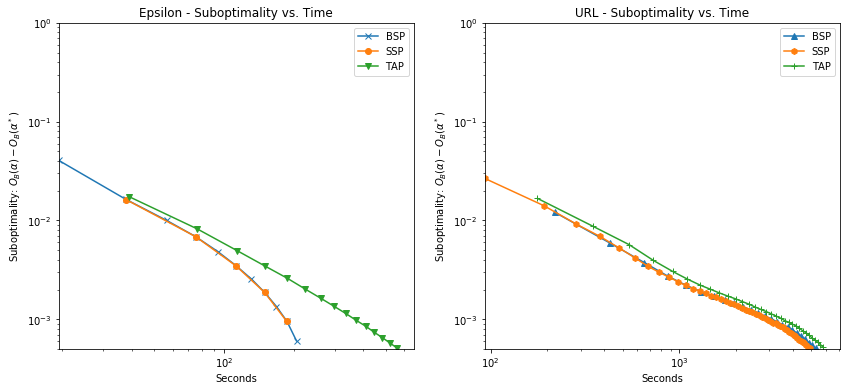

In [24]:
plotter = ExperimentDoubleLogPlotter()
# Epsilon
plotter.add_experiment(parser_framework_2.parse(sst_epsilon_framework_bsp, no_params=True), subplot=1, name='BSP', every_n=50)
plotter.add_experiment(parser_framework_2.parse(sst_epsilon_framework_ssp, no_params=True), subplot=1, name='SSP', every_n=100)
plotter.add_experiment(parser_framework_2.parse(sst_epsilon_framework_tap, no_params=True), subplot=1, name='TAP', every_n=100)
# URL
plotter.add_experiment(parser_spark.parse(sst_url_framework_bsp, no_params=True), subplot=2, name='BSP', every_n=100)
plotter.add_experiment(parser_spark.parse(sst_url_framework_ssp, no_params=True), subplot=2, name='SSP', every_n=50)
plotter.add_experiment(parser_spark.parse(sst_url_framework_tap, no_params=True), subplot=2, name='TAP', every_n=100)

plotter.ylabel(r'Suboptimality: $O_B(\alpha) - O_B(\alpha^*)$')
plotter.ylim(5e-4)
plotter.figsize((14, 6))
plotter.title('Epsilon - Suboptimality vs. Time', subplot=1)
plotter.title('URL - Suboptimality vs. Time', subplot=2)
#plotter.use_iterations()

plotter.add_min_objectives(objective=0.21719526, subplot=1)
plotter.add_min_objectives(objective=0.046094768, subplot=2)

plotter.plot(filename='./../img/sync_strat_cmp.png')

## Merging Strategy

### Results - Epsilon

In [25]:
merg_epsilon_add = base_path + 'exa/exp_exa_epsilon_h01_s3/exp_exa_epsilon_h01_s3_091.txt'
merg_epsilon_avg = base_path + 'exa/exp_exa_epsilon_h01_s3_avg/exp_exa_epsilon_h01_s3_avg_091.txt'

### Results - URL

In [26]:
merg_url_add = base_path + 'exa/exp_exa_url_h02_s3/exp_exa_url_h02_s3_091.txt'
merg_url_avg = base_path + 'exa/exp_exa_url_h02_s3_avg/exp_exa_url_h02_s3_avg_091.txt'

### Figure

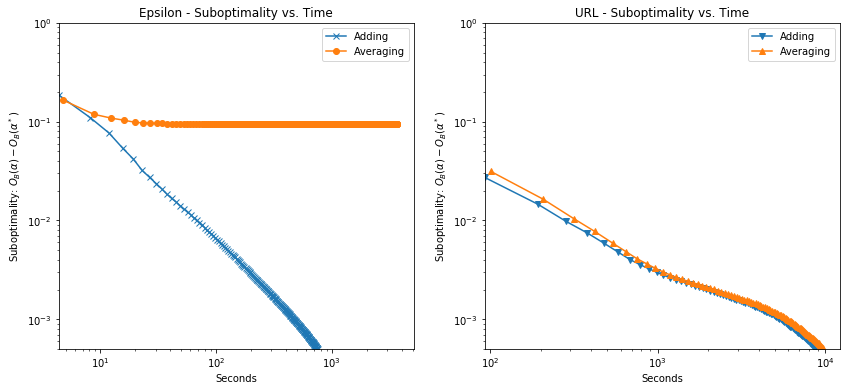

In [27]:
plotter = ExperimentDoubleLogPlotter()
# Epsilon
plotter.add_experiment(parser_framework_2.parse(merg_epsilon_add, no_params=True), subplot=1, name=r'Adding', every_n=10)
plotter.add_experiment(parser_framework_2.parse(merg_epsilon_avg, no_params=True), subplot=1, name='Averaging', every_n=10)
# URL
plotter.add_experiment(parser_framework_2.parse(merg_url_add, no_params=True), subplot=2, name='Adding', every_n=50)
plotter.add_experiment(parser_framework_2.parse(merg_url_avg, no_params=True), subplot=2, name='Averaging', every_n=50)

plotter.ylabel(r'Suboptimality: $O_B(\alpha) - O_B(\alpha^*)$')
plotter.ylim(5e-4)
plotter.figsize((14, 6))
plotter.title('Epsilon - Suboptimality vs. Time', subplot=1)
plotter.title('URL - Suboptimality vs. Time', subplot=2)
#plotter.use_iterations()

plotter.add_min_objectives(objective=0.21497042, subplot=1)
plotter.add_min_objectives(objective=0.045502, subplot=2)

plotter.plot(filename='./../img/merg_strat_cmp.png')

## Filter Strategy

### Results - URL

In [28]:
filt_url_baseline = base_path + 'exa/exp_exa_url_h02_s3/exp_exa_url_h02_s3_091.txt'
filt_url_rr = base_path + 'exa/exp_exa_url_h02_s3_rr/exp_exa_url_h02_s3_rr_091.txt'
filt_url_rnd = base_path + 'exa/exp_exa_url_h02_s3_rnd_2/exp_exa_url_h02_s3_rnd_2_091.txt'
filt_url_am = base_path + 'exa/exp_exa_url_h02_s3_am/exp_exa_url_h02_s3_am_091.txt'
filt_url_rm = base_path + 'exa/test7.txt'

### Figure

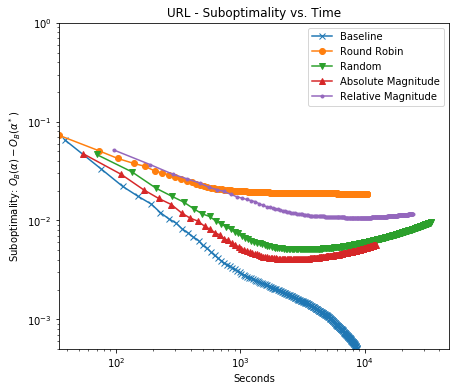

In [29]:
plotter = ExperimentLogPlotter()
# UR
plotter.add_experiment(parser_framework_2.parse(filt_url_baseline, no_params=True), name='Baseline', every_n=20)
plotter.add_experiment(parser_framework_2.parse(filt_url_rr, no_params=True), name='Round Robin', every_n=20)
plotter.add_experiment(parser_framework_2.parse(filt_url_rnd, no_params=True), name='Random', every_n=20)
plotter.add_experiment(parser_framework_2.parse(filt_url_am, no_params=True), name='Absolute Magnitude', every_n=20)
plotter.add_experiment(parser_framework_2.parse(filt_url_rm, no_params=True), name='Relative Magnitude', every_n=20)

plotter.ylabel(r'Suboptimality: $O_B(\alpha) - O_B(\alpha^*)$')
plotter.ylim(5e-4)
plotter.figsize((7, 6))
plotter.title('Epsilon - Suboptimality vs. Time')
plotter.title('URL - Suboptimality vs. Time')
#plotter.use_iterations()
plotter.add_min_objective(0.045502)

plotter.plot(filename='./../img/filter_strat_cmp.png')